In [1]:
import modules.board_module as bf
import modules.tree_module as tf
import modules.stockfish_module as sf
from ModelSaver import ModelSaver
import random
from dataclasses import dataclass
from collections import namedtuple
import itertools
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import datetime
from math import floor, ceil

from train_nn_evaluator import Trainer, EvalDataset, ChessNet, ResNet

In [2]:
# load in the entire dataset
num_rand = 4096
datapath = "/home/luke/chess/python/gamedata/samples"
eval_file_template = "random_n={0}_sample"
inds = list(range(1))
log_level = 1
dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                      indexes=inds, log_level=log_level)

Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_200.lz4 with pickle ... finished
EvalDataset(): 1 files loaded 0.20 seconds


In [3]:
process_data = False

if process_data:

  print(f"Total number of positions = {len(dataset)}")
  num_duplicates = dataset.check_duplicates()
  num_mates = dataset.check_mate_positions()
  print(f"Proportion of duplicates = {(num_duplicates / len(dataset))*100:.1f} %")
  print(f"Proportion of mate positions = {(num_mates / len(dataset))*100:.1f} %")

  # prepare the dataset
  print("REMOVING MATES AND DUPLICATES")
  num_duplicates = dataset.check_duplicates(remove=True)
  num_mates = dataset.check_mate_positions(remove=True)
  dataset.board_dtype = torch.float
  dataset.to_torch()

In [4]:
savenew = False

if savenew:

  dataset_name = "datasetv2"
  file_name = "data"
  ind_per = 2               # indexes per slice of the dataset
  total_index = 140         # largest index number of gamedata/samples file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  savetorchonly = False     # save only the finalised torch tensors
  savetorchtoo = True       # save also a torch version of the dataset
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)

  num_sets = total_index // ind_per
  if prevent_duplicates: seen_values = set()

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  for ind in range(num_sets):

    print("Loading set", ind + 1, "/", num_sets)
    indexes = list(range(ind * ind_per + 1, ((ind + 1) * ind_per) + 1))
    dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                          indexes=indexes, log_level=log_level)
    if prevent_duplicates: dataset.seen_values = seen_values
    num_duplicates = dataset.check_duplicates(remove=True, wipe_seen=not prevent_duplicates)
    num_mates = dataset.check_mate_positions(remove=True)
    dataset.board_dtype = torch.float
    dataset.to_torch()
    if savetorchonly or savetorchtoo:
      if dataset.eval_squares:
        datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals, dataset.square_evals])
      else:
        datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals])
    elif not savetorchonly:
      datasaver.save(file_name, dataset)
    if prevent_duplicates: seen_values = dataset.seen_values

In [ ]:
savenew_randomised = True

if savenew_randomised:

  dataset_name = "datasetv5"
  file_name = "data"
  max_files = None          # maximum number of files to generate, default=None
  num_per = 200_000         # number of lines per saved file
  total_index = 200         # largest index number of gamedata/samples file
  prevent_duplicates = True # prevent duplicates across the entire set, not just in each slice
  log_level = 1             # log level during the dataset generation (0=bare minimum, 1=normal)

  datasaver = ModelSaver("/home/luke/chess/python/datasets/", log_level=log_level)
  datasaver.new_folder(dataset_name)

  indexes = list(range(1, total_index + 1))
  dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                          indexes=indexes, log_level=log_level)
  
  # ensure key settings are correct
  dataset.use_eval_normalisation = False
  dataset.save_sq_eval = True

  # remove any duplicates and mate positions
  num_duplicates = dataset.check_duplicates(remove=True)
  num_mates = dataset.check_mate_positions(remove=True)
  # dataset.to_torch() # old, convert ALL to torch

  # now randomise a selection of the indexes
  num_boards = dataset.count_all_positions()
  indexes = list(range(num_boards))
  random.shuffle(indexes)

  num_files = num_boards // num_per
  ind = 0

  if max_files is not None:
    if num_files > max_files:
      print(f"The number of files is limited from {num_files} to {max_files}")
      num_files = max_files

  print("num_files is", num_files)
  print("num_boards is", num_boards)
  
  for n in range(num_files):

    # random selection of indexes for the current file
    these_indexes = indexes[n * num_per : (n + 1) * num_per]
    
    # convert only the selected indexes to torch
    dataset.to_torch(indexes_only=these_indexes)

    # save the converted tensors
    datasaver.save(file_name + "_torch", [dataset.boards, dataset.evals, dataset.square_evals])

    # boards = torch.zeros((num_per, *dataset.boards[0].shape))
    # evals = torch.zeros((num_per))
    # sq_evals = torch.zeros((num_per, *dataset.square_evals[0].shape))

    # for i in range(num_per):

    #   boards[i] = dataset.boards[indexes[ind]]
    #   evals[i] = dataset.evals[indexes[ind]]
    #   sq_evals[i] = dataset.square_evals[indexes[ind]]

    #   # increment to the next random index
    #   ind += 1

    # datasaver.save(file_name + "_torch", [boards, evals, sq_evals])

Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_001.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_002.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_003.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_004.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_005.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_006.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_007.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_008.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_009.lz4 with pickle ... finished
Loading file /home/luke/ches

In [6]:
def normalise_data(data, factors, clip=None):
  """
  Normalise data based on [max, mean, std]
  """
  max, mean, std = factors
  d = ((data - mean) / std) / max
  if clip is not None:
    d = torch.clip(d, min=-clip, max=clip)
  return d

examine = False

if examine:

  factors = [23.927, -0.240, 0.355]
  factors = [3, -0.240, 0.355]
  norm_evals = normalise_data(dataset.evals, factors, clip=1)

  fig, axs = plt.subplots(1, 1)
  axs.hist(norm_evals.numpy(), bins=50)
  plt.show()

  print(torch.max(dataset.evals))
  print(torch.min(dataset.evals))

In [7]:
rexamine = False

if rexamine:

  # load all of the dataset files to examine the data distribution
  max_values = []
  mean_values = []
  std_values = []
  for i in range(1, 11):
    this_data = datasaver.load("datasetv1", id=i)
    this_data.normalise_evaluations()
    max_values.append(this_data.norm_factor[0])
    mean_values.append(this_data.norm_factor[1])
    std_values.append(this_data.norm_factor[2])

  true_max = np.max(max_values)
  avg_mean = np.mean(mean_values)
  avg_std = np.mean(std_values)

  print(f"True max = {true_max:.3f}, true mean = {avg_mean:.3f}, average std = {avg_std:.3f}")

  norm_factors = [true_max, avg_mean, avg_std]

else:
  # True max = 23.927, true mean = -0.240, average std = 0.355
  norm_factors = [23.927, -0.240, 0.355]


In [8]:
def normalise_data(data, factors):
  """
  Normalise data based on [max, mean, std]
  """
  max, mean, std = factors
  return ((data - mean) / std) / max

def denormalise_data(data, factors):
  """
  Undo normalisation based on [max, mean, std]
  """
  max, mean, std = factors
  return (data * max * std) + mean

def train_procedure(net, dataname, dataloader, data_inds, norm_factors,
                    epochs=1, lr=1e-7, device="cuda", batch_size=64,
                    loss_style="MSE"):
  """
  Perform a training epoch for a given network based on data inputs
  data_x, and correct outputs data_y
  """

  # move onto the specified device
  net.board_cnn.to(device)

  # put the model in training mode
  net.board_cnn.train()

  if loss_style.lower() == "mse":
    lossfcn = nn.MSELoss()
  elif loss_style.lower() == "l1":
    lossfcn = nn.L1Loss()
  elif loss_style.lower() == "huber":
    lossfcn = nn.HuberLoss()
  else:
    raise RuntimeError(f"train_procedure() error: loss_style = {loss_style} not recognised")

  optim = torch.optim.Adam(net.board_cnn.parameters(), lr=lr)
  
  # each epoch, cover the entire training dataset
  for i in range(epochs):

    print(f"Starting epoch {i + 1}.")
    total_batches = 0
    epoch_loss = 0

    # load the dataset in a series of slices
    for slice_num, j in enumerate(data_inds):

      # load this segment of the dataset
      dataset = dataloader.load(dataname, id=j)
      data_x = dataset.boards
      data_y = dataset.evals

      # import sys
      # print("The size in bytes of data_x", sys.getsizeof(data_x.storage()))
      # print("The size in bytes of data_y", sys.getsizeof(data_y.storage()))

      # normalise y labels
      data_y = normalise_data(data_y, norm_factors)

      num_batches = len(data_x) // batch_size
      total_batches += num_batches
      rand_idx = torch.randperm(data_x.shape[0])
      avg_loss = 0

      print(f"Starting slice {slice_num + 1} / {len(data_inds)}. There will be {num_batches} batches. ", end="", flush=True)

      # iterate through each batch for this slice of the dataset
      for n in range(num_batches):

        batch_x = data_x[rand_idx[n * batch_size : (n+1) * batch_size]]
        batch_y = data_y[rand_idx[n * batch_size : (n+1) * batch_size]]

        # go to cuda
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # use the model for a prediction and calculate loss
        net_y = net.board_cnn(batch_x)
        loss = lossfcn(net_y.squeeze(1), batch_y)

        # backpropagate
        loss.backward()
        optim.step()
        optim.zero_grad()

        avg_loss += loss.item()

        # if n % 500 == 0:
        #   print(f"Loss is {(avg_loss / (n + 1)) * 1000:.3f}, epoch {i + 1}, batch {n + 1} / {num_batches}")

      # this dataset slice is finished
      epoch_loss += avg_loss
      avg_loss = avg_loss / num_batches
      avg_loss = avg_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
      print(f"Loss is {avg_loss:.3f}, during epoch {i + 1}, slice {slice_num + 1} / {len(data_inds)}", flush=True)
  
    # this epoch is finished
    epoch_loss = epoch_loss / total_batches
    epoch_loss = epoch_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
    print(f"Epoch {i + 1} has finished after {total_batches} batches. Overall average loss = {epoch_loss:.3f}", flush=True)

  # finally, return the network that we have trained
  return net

do_train_procedure = False

if do_train_procedure:

  net = ChessNet(19)

  device = "cuda"
  epochs = 10
  data_inds = list(range(1, 11))
  lr = 1e-7

  trained_net = train_procedure(
    net=net,
    dataname="datasetv1",
    dataloader=ModelSaver("/home/luke/chess/python/datasets/", log_level=1),
    data_inds=list(range(1, 11)),
    norm_factors=[23.927, -0.240, 0.355], # [max, mean, std]
    epochs=epochs,
    lr=lr,
    device=device    
  )

In [ ]:
def torch_to_board_vec(tensor):
  """
  Convert a torch board vector into a cpp board vector
  """

  boardvec = bf.BoardVectors()

  boardvec.wP = list(tensor[0].reshape(64))
  boardvec.wN = list(tensor[1].reshape(64))
  boardvec.wB = list(tensor[2].reshape(64))
  boardvec.wR = list(tensor[3].reshape(64))
  boardvec.wQ = list(tensor[4].reshape(64))
  boardvec.wK = list(tensor[5].reshape(64))
  boardvec.bP = list(tensor[6].reshape(64))
  boardvec.bN = list(tensor[7].reshape(64))
  boardvec.bB = list(tensor[8].reshape(64))
  boardvec.bR = list(tensor[9].reshape(64))
  boardvec.bQ = list(tensor[10].reshape(64))
  boardvec.bK = list(tensor[11].reshape(64))
  boardvec.wKS = list(tensor[12].reshape(64))
  boardvec.wQS = list(tensor[13].reshape(64))
  boardvec.bKS = list(tensor[14].reshape(64))
  boardvec.bQS = list(tensor[15].reshape(64))
  boardvec.colour = list(tensor[16].reshape(64))

  return boardvec

loadexisting = True

if loadexisting:

  if False:
    modelloader = ModelSaver("/home/luke/chess/python/models/")
    trained_net = modelloader.load("chessnet_model", id=None)
  else:
    group = "05-11-24"
    run = "run_17-09_A8"
    modelloader = ModelSaver(f"/home/luke/chess/python/models/{group}/{run}")
    trained_net = modelloader.load("network", id=None)
  
  dataset_name = "sf_dist_1"
  dataset_ind = 1
  dataloader = ModelSaver(f"/home/luke/chess/python/datasets/{dataset_name}")
  boards, evals, sq_evals = dataloader.load("data_torch", id=dataset_ind)

  device = "cuda"
  trained_net.board_cnn.to(device)
  boards = boards.to(device)
  evals = evals.to(device)
  sq_evals = sq_evals.to(device)

  trained_net.board_cnn.eval()

rand = False
inds = list(range(len(evals)))
if rand:
  random.shuffle(inds)

my_diff_vec = []
sf_diff_vec = []
sf_vec = []

avg_diff_sf = 0
avg_diff_my = 0
n = 1000
inds = inds[:n]
for i in inds:

  # # evaluation comparison
  # sf_eval = dataset.positions[i].eval
  # net_eval = trained_net.board_cnn(dataset.boards[i].to(device).unsqueeze(dim=0))
  # net_eval = net_eval.to("cpu").item()
  # if dataset.use_eval_normalisation:
  #   net_eval = dataset.denomormalise_evaluation(value=net_eval)
  # diff = abs(sf_eval*1e-3 - net_eval)
  # avg_diff += diff
  # if n <= 20:
  #   print(f"sf_eval = {sf_eval * 1e-3:.3f}, net_eval = {net_eval:.3f}, difference is {diff:.3f}")

  # board piece rating comparison
  net_eval = (trained_net.board_cnn(boards[i].unsqueeze(dim=0))).to("cpu")
  net_eval = denormalise_data(net_eval, factors=[7, 0, 2.159])

  this_board_vec = boards[i].to("cpu")
  this_sf_eval = evals[i].to("cpu")
  this_sq_evals = sq_evals[i].to("cpu")

  # board_vec = bf.FEN_to_board_vectors_with_eval(dataset.positions[i].fen_string)
  # board_vec = torch.tensor(board_vec.sq_evals, dtype=torch.float) * 1e-3
  
  net_overall = torch.sum(net_eval)
  true_overall = torch.sum(this_sq_evals)

  net_print = torch.zeros((8, 8))
  true_print = torch.zeros((8, 8))
  
  torch.round(net_eval.reshape(8,8).detach(), decimals=2, out=net_print)
  torch.round(this_sq_evals.reshape(8,8).detach(), decimals=2, out=true_print)

  sf_diff = this_sf_eval - net_overall
  my_diff = true_overall - net_overall

  my_diff_vec.append(my_diff.detach().item())
  sf_diff_vec.append(sf_diff.detach().item())
  sf_vec.append(this_sf_eval.detach().item())

  avg_diff_sf += abs(sf_diff)
  avg_diff_my += abs(my_diff)
  
  if n <= 50:
    print(f"Case {i + 1} / {n}.", end=" ")
    if n < 6:
      print("Board:")
      bf.print_board_vectors(torch_to_board_vec(this_board_vec))
      # bf.print_FEN_board(dataset.positions[i].fen_string)
      print("Net eval was\n", net_print)
      print("Ground truth was\n", true_print)
    print(f"sf_eval = {this_sf_eval:.3f}, True evaluation = {true_overall:.3f}, net eval = {net_overall:.3f}, difference = {true_overall - net_overall:.3f}")

diff_sf = np.array(sf_diff_vec)
mean_sf_diff = np.mean(np.abs(diff_sf))
std_sf_diff = np.std(diff_sf)

diff_my = np.array(my_diff_vec)
mean_my_diff = np.mean(np.abs(diff_my))
std_my_diff = np.std(diff_my)

sf_vec = np.array(sf_vec)

print(f"The average difference from {n} samples is u={mean_my_diff:.3f} s={std_my_diff:.3f}, stockfish average difference is u={mean_sf_diff:.3f} s={std_sf_diff:.3f}")

Loading file /home/luke/chess/python/models/05-11-24/run_17-09_A8/network_005.lz4 with pickle ... finished
Loading file /home/luke/chess/python/datasets/sf_dist_1/data_torch_001.lz4 with pickle ... finished
The average difference from 10000 samples is u=3.633 s=4.479, stockfish average difference is u=3.706 s=5.176


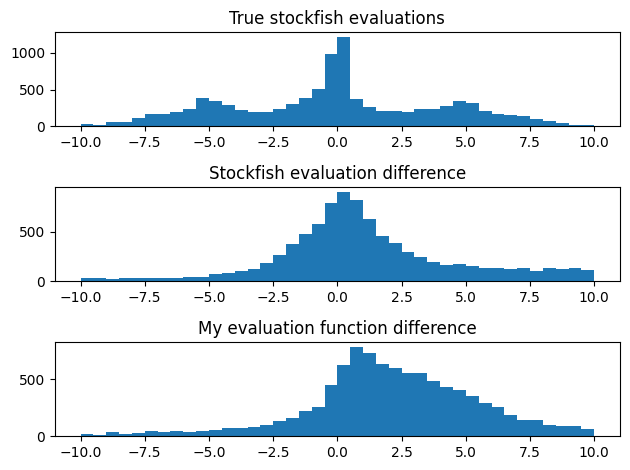

In [13]:
fig, axs = plt.subplots(3, 1)
axs[0].hist(sf_vec, bins=40, range=(-10, 10))
axs[1].hist(diff_sf, bins=40, range=(-10, 10))
axs[2].hist(diff_my, bins=40, range=(-10, 10))
axs[0].set_title("True stockfish evaluations")
axs[1].set_title("Stockfish evaluation difference")
axs[2].set_title("My evaluation function difference")
fig.tight_layout()
plt.show()

In [14]:
torch.max(evals)
x = 13
for i in range(len(dataset.positions[x].move_vector)):
  print(f"Move: {dataset.positions[x].move_vector[i].move_letters}, eval = {dataset.positions[x].move_vector[i].eval}")

Move: d8g5, eval = -746
Move: d8f6, eval = -737
Move: d8h4, eval = -689
Move: f8d6, eval = -445
Move: c6e5, eval = -420
Move: g7h5, eval = -410
Move: e8e7, eval = -376
Move: c6b4, eval = -357
Move: g7f5, eval = -347
Move: c6d4, eval = -345
Move: g6g5, eval = -227
Move: d5d4, eval = -120
Move: c6b8, eval = -95
Move: d7c8, eval = -91
Move: c6a5, eval = -89
Move: b7b5, eval = -88
Move: a8b8, eval = -75
Move: d8c8, eval = -74
Move: b7b6, eval = -70
Move: d8b8, eval = -69
Move: c6e7, eval = -65
Move: f7f6, eval = -62
Move: c5c4, eval = -60
Move: h8g8, eval = -60
Move: d8a5, eval = -60
Move: d8e7, eval = -59
Move: a8c8, eval = -54
Move: f7f5, eval = -52
Move: a7a5, eval = -51
Move: d8c7, eval = -25
Move: f8e7, eval = -21
Move: h7h6, eval = -8
Move: a7a6, eval = 8
Move: h7h5, eval = 20
Move: d8b6, eval = 20


In [15]:
time_net = True

if time_net:

  timedevice = "cuda"
  trained_net.board_cnn.eval()
  trained_net.board_cnn.to(timedevice)
  num = 1000
  j = 0

  t1 = time.process_time()
  for i in range(num):
    trained_net.board_cnn(dataset.boards[j].to(timedevice).unsqueeze(dim=0))
    j += 1
    if j >= len(dataset.boards):
      j = 0
  t2 = time.process_time()

  print(f"Network: Total time {t2 - t1:.1f}s, so {((t2 - t1) / num) * 1e3:.3f} ms per evaluation")

  t1 = time.process_time()
  for i in range(num):
    bf.generate_moves_FEN(dataset.positions[j].fen_string)
    j += 1
    if j >= len(dataset.boards):
      j = 0
  t2 = time.process_time()

  print(f"Handcrafted: Total time {t2 - t1:.1f}s, so {((t2 - t1) / num) * 1e3:.3f} ms per evaluation")

Network: Total time 4.7s, so 4.663 ms per evaluation
Handcrafted: Total time 0.5s, so 0.481 ms per evaluation
